<a href="https://colab.research.google.com/github/wisnuajalah/Stock-Price/blob/main/Stock_Price_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# mounting dataset dari gdrive
drive.mount('/content/gdrive', force_remount=True)

# folder ini juga digunakan untuk menyimpan model yang sudah dilatih
root_path = 'gdrive/My Drive/Colab Notebooks/Skripsi/'

# opsional - tampilkan info lokasi dataset
print("Path root:", root_path)

Mounted at /content/gdrive
Path root: gdrive/My Drive/Colab Notebooks/Skripsi/


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

In [ ]:
#Memuat data dari file CSV
file_path = root_path + "BRIS.JK.csv"
df = pd.read_csv(file_path, encoding='utf-8', sep=';')

# Menampilkan beberapa baris pertama data
print(df.head())

         Date         Open         High          Low        Close  \
0  09/05/2018  585.185.303  614.444.580  507.160.583  531.543.335   
1  10/05/2018          NaN          NaN          NaN          NaN   
2  11/05/2018  536.419.861  643.703.857  536.419.861  604.691.467   
3  14/05/2018  604.691.467  633.950.745  585.185.303  585.185.303   
4  15/05/2018  585.185.303  585.185.303  585.185.303  585.185.303   

     Adj Close  Adj_Close       Volume  
0  516.593.567      516.0  282154012.0  
1          NaN        NaN          NaN  
2  587.684.326      587.0  292500171.0  
3  568.726.868      568.0  127848119.0  
4  568.726.868      568.0          0.0  


In [ ]:
# Cek data yang hilang
print(df.isnull().sum())

# Hapus baris dengan data yang hilang (jika diperlukan)
df.dropna(inplace=True)

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Adj_Close    1
Volume       1
dtype: int64


In [ ]:
print(df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Adj_Close',
       'Volume'],
      dtype='object')


In [ ]:
# Menggunakan hanya kolom 'Adj_Close' untuk prediksi
data = df['Adj_Close'].values.reshape(-1, 1)
print(df['Adj_Close'])

0        516.0
2        587.0
3        568.0
4        568.0
5        568.0
         ...  
1547    2640.0
1548    2680.0
1549    2620.0
1550    2700.0
1551    2730.0
Name: Adj_Close, Length: 1551, dtype: float64


In [ ]:
# Normalisasi data untuk LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [ ]:
# Membuat dataset untuk LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [ ]:
# Misalkan kita menggunakan 60 hari untuk prediksi
time_step = 60
X, y = create_dataset(scaled_data, time_step)

In [ ]:
# Membagi data menjadi training dan testing
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [ ]:
# Mengubah data untuk dimasukkan ke dalam LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Kompilasi model
model.compile(optimizer='Adam', loss='mean_squared_error')

In [ ]:
# Menyimpan model terbaik selama pelatihan
checkpoint_filepath = 'best_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
# Melatih model
history = model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test), callbacks=[model_checkpoint_callback])

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0120 - val_loss: 0.0034
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0028 - val_loss: 7.2554e-04
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - val_loss: 8.0883e-04
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - val_loss: 5.2611e-04
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0014 - val_loss: 8.1648e-04
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0016 - val_loss: 4.7962e-04
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 8.4344e-04
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - val_loss: 8.2053e-04
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 6.9324e-04
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━

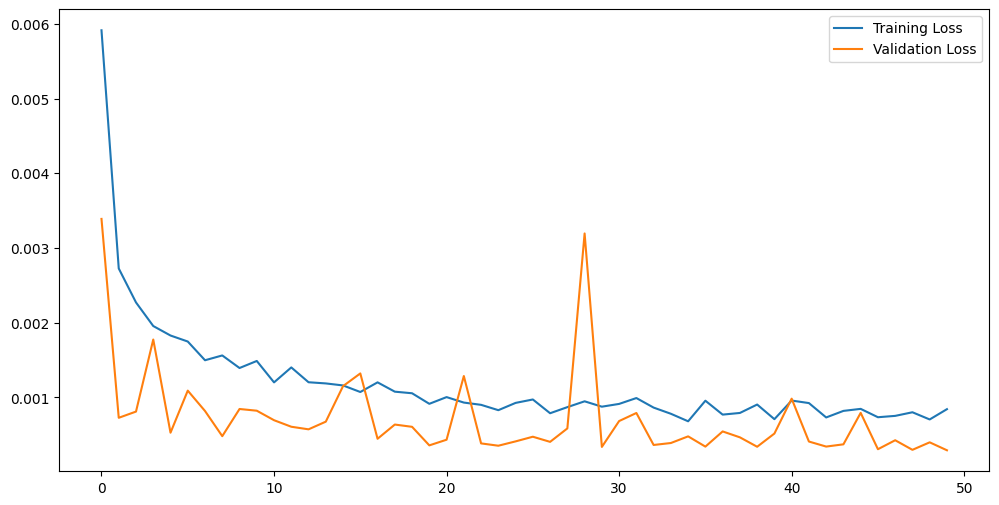

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Melakukan prediksi
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
# Mengembalikan skala data ke bentuk asli
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
# Mengembalikan skala y_train dan y_test ke bentuk asli
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [ ]:
# Menghitung Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))

# Menghitung Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(y_train[0], train_predict[:, 0])
test_mape = mean_absolute_percentage_error(y_test[0], test_predict[:, 0])

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAPE: {train_mape}')
print(f'Test MAPE: {test_mape}')


Train RMSE: 59.92583665355032
Test RMSE: 58.84627053355136
Train MAPE: 3.370506859549326
Test MAPE: 1.913078952515055


In [ ]:
# Make sure that this is the correct path to your saved model
checkpoint_filepath = 'best_model.keras'
trained_model = load_model(checkpoint_filepath)

In [ ]:
# Reshape X_test to 3D [samples, time steps, features]
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Reshape y_test to 2D [samples, output features]
y_test = y_test.reshape(y_test.shape[1], 1)

# Test the model
test_loss = trained_model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3370357.2500  
Test Loss: 4260712.0


In [ ]:
# Menghitung akurasi sebagai 100% - MAPE
test_accuracy = 100 - test_mape

In [ ]:
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Test Loss: 4260712.0
Test Accuracy: 98.08692104748495


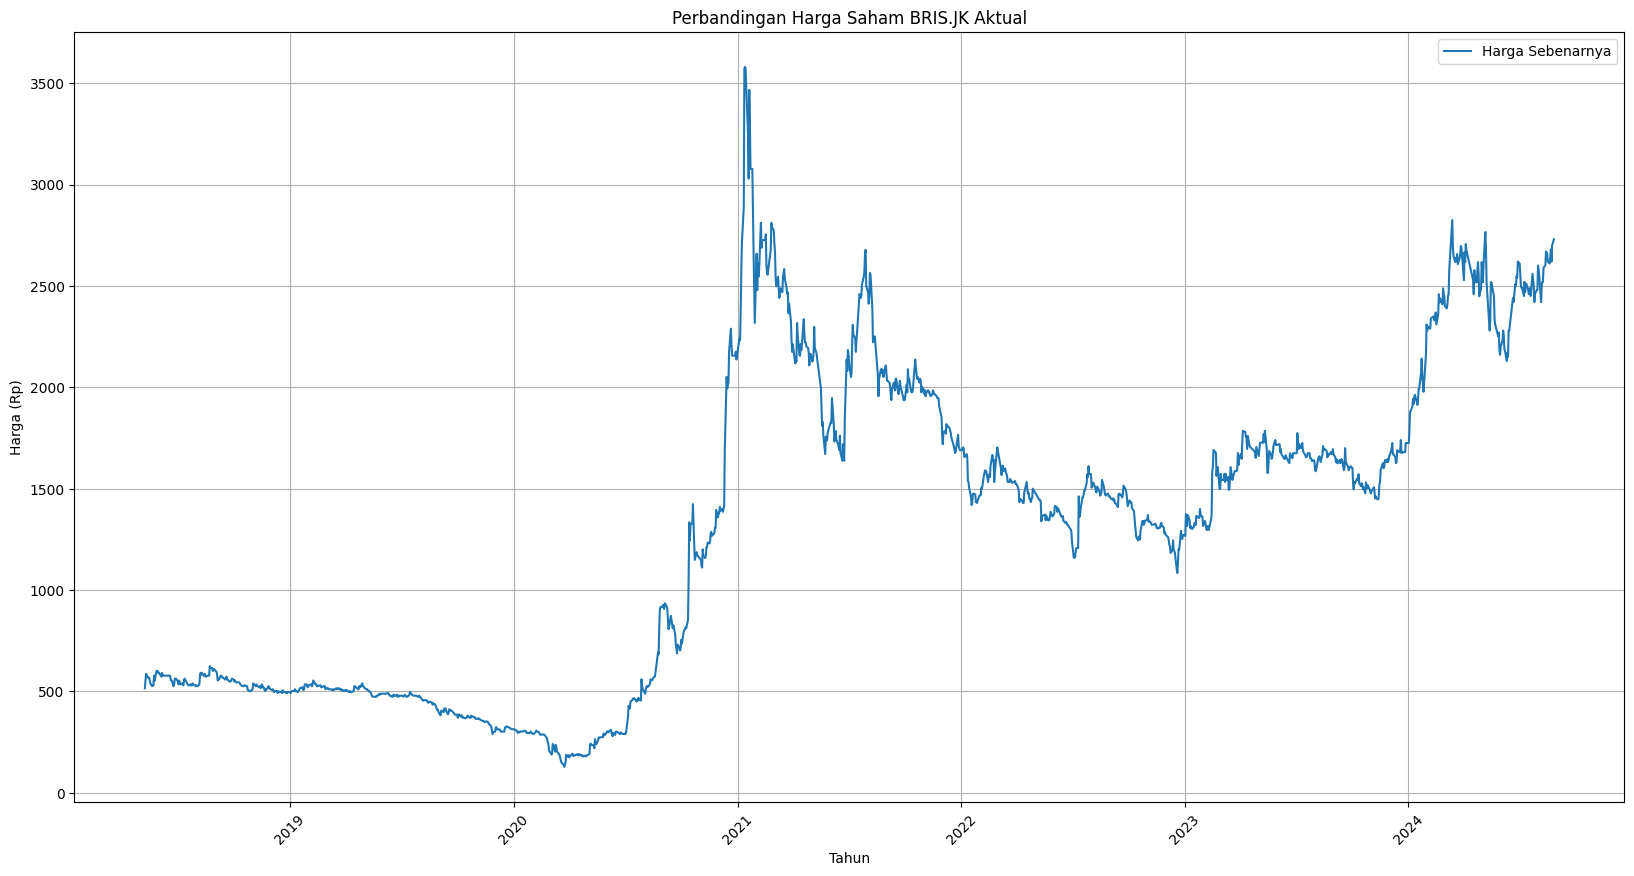

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ubah indeks df menjadi datetime dengan format yang sesuai
df.index = pd.to_datetime(df['Date'], format='%d/%m/%Y') # Changed the format to match the date format in the dataframe

# Plot harga aktual
plt.figure(figsize=(20, 10))
plt.plot(df.index, df['Adj_Close'], label='Harga Sebenarnya')

# Set label sumbu
plt.xlabel('Tahun')
plt.ylabel('Harga (Rp)')

# Format tanggal pada sumbu x (menampilkan tahun saja)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)


# Tambahkan judul dan grid
plt.title('Perbandingan Harga Saham BRIS.JK Aktual')
plt.grid(True)

plt.legend()
plt.show()

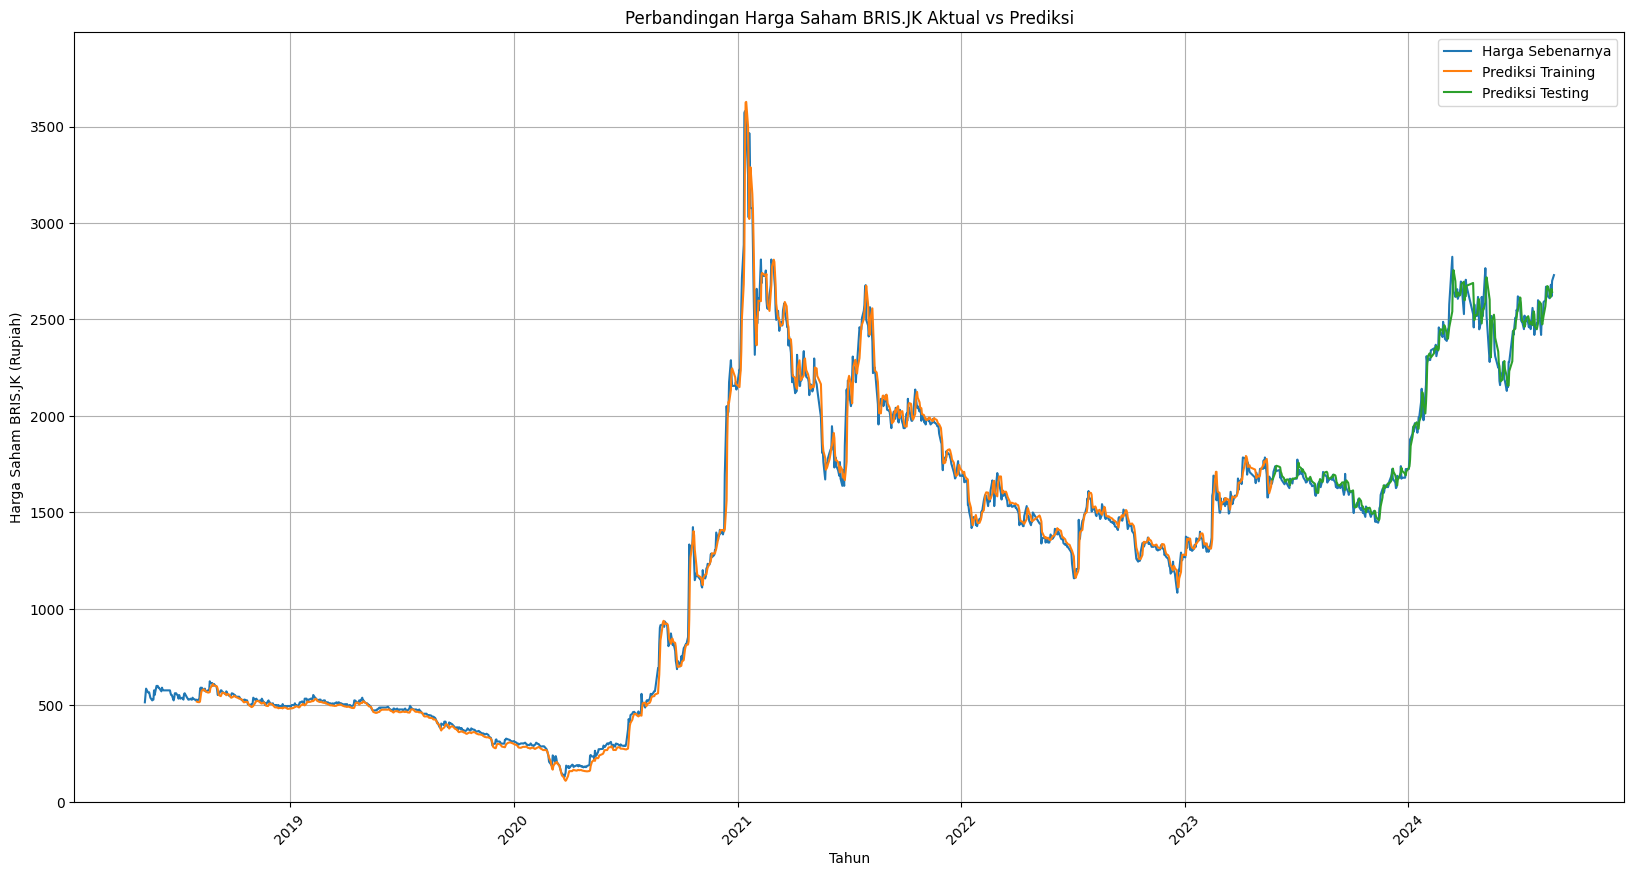

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# ... (kode program hingga bagian plot prediksi)

# Ubah indeks df menjadi datetime dengan format yang sesuai
df.index = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Plot harga aktual
plt.figure(figsize=(20, 10))
plt.plot(df.index, df['Adj_Close'], label='Harga Sebenarnya')

# Plot prediksi training dan testing
# The slice now includes all training predictions and accounts for the time_step
plt.plot(df.index[time_step:len(train_predict) + time_step], train_predict, label='Prediksi Training')

# Pastikan test_predict memiliki dimensi yang sama dengan sumbu x
# Calculate the correct starting index for test predictions
# Removed +1 from the original calculation to ensure the correct number of elements
start_index = len(train_predict) + time_step
plt.plot(df.index[start_index:start_index + len(test_predict)], test_predict, label='Prediksi Testing')

# Set label sumbu
plt.xlabel('Tahun')
plt.ylabel('Harga Saham BRIS.JK (Rupiah)')
# Sesuaikan batas y jika perlu
plt.ylim(0, max(df['Adj_Close'].max(), train_predict.max(), test_predict.max()) * 1.1)

# Format tanggal pada sumbu x (menampilkan tahun saja)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Tambahkan judul dan grid
plt.title('Perbandingan Harga Saham BRIS.JK Aktual vs Prediksi')
plt.grid(True)

plt.legend()
plt.show()